# Ряды. ДЗ №4. Модели GARCH

In [90]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg,  ar_select_order
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from math import sqrt

In [91]:
# формируем датафрейм - количество продаж за месяц
# используем данные и расчеты предыдущего домашнего задания

sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
sales_of_company_x["Month"] = pd.to_datetime(sales_of_company_x["Month"])
sales_of_company_x2=sales_of_company_x
sales_of_company_x.set_index('Month', inplace = True)

df = pd.Series(sales_of_company_x["Count"])
df

Month
1965-01-01    154
1965-02-01     96
1965-03-01     73
1965-04-01     49
1965-05-01     36
             ... 
1971-01-01    628
1971-02-01    308
1971-03-01    324
1971-04-01    248
1971-05-01    272
Name: Count, Length: 77, dtype: int64

In [92]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [93]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Определим базовые характерисики ряда и проверим его на условие стационарности

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


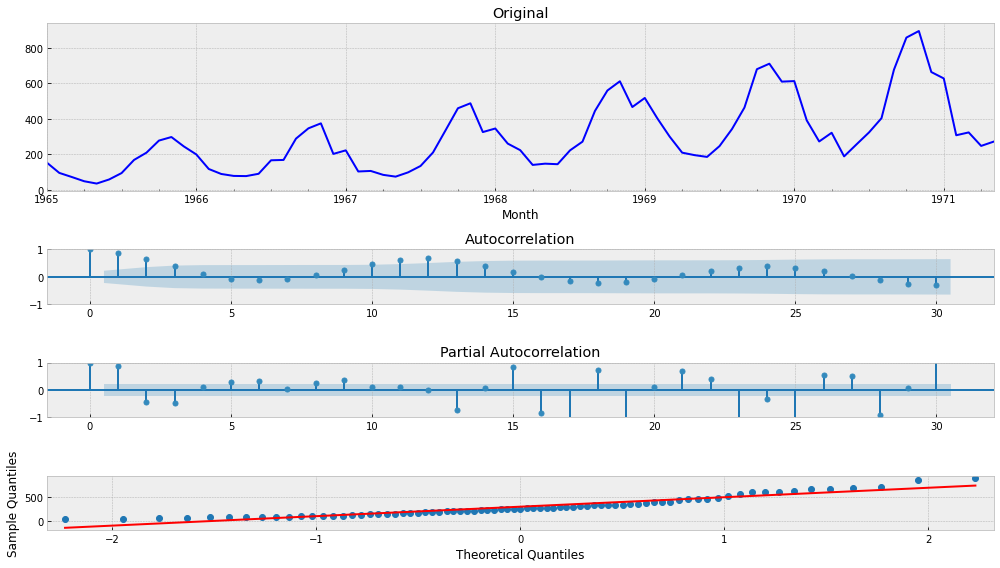

In [94]:
tsplot(df, lags=30)

Приведем ряд к стационарному виду.
Изменение дисперсии скорректируем преобразованием Бокса-Кокса, наличие тренда с помощью диффиренцирования

In [95]:
#ADF-test(differenced-time-series)
df2 = pd.Series(boxcox(df, 0)) # преобразование Бокса-Кокса
df3 = pd.Series(df2.diff())
df4 = sm.tsa.adfuller(df3.dropna(),regression='c')
print('p-value:{}'.format(df4[1]))
# сформируем стационарный ряд (датафрейм)
df3s = pd.DataFrame({"Count": df3})
df3s = df3s.dropna()
df3s.index = df.index[1:]

p-value:0.02402539283987568


Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


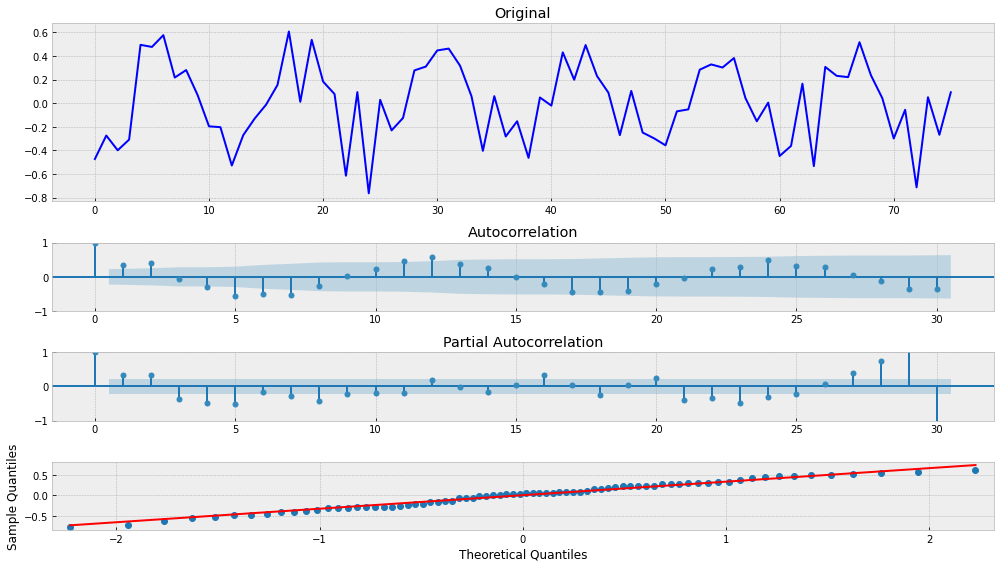

In [96]:
tsplot(np.diff(df2), lags=30)

В итоге получаем стационарный ряд

Найдем оптимальные параметры модели ARIMA (p,d,q)

In [97]:
import itertools
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
#df = pd.Series(dowjones_closing["Close"])
df=pd.Series(sales_of_company_x ["Count"])

p = range(0,5)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(df, order = params)
  result_test = model_test.fit()
  if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

(3, 1, 2) 858.2121934112151


эти параметры дают более высокое значение AIC поэтому в дальнейшем будем использовать их

In [98]:
arma_mod = ARIMA(df, order=best_pdq).fit()
print(arma_mod.params)

ar.L1        1.357971
ar.L2       -0.375270
ar.L3       -0.349689
ma.L1       -1.794245
ma.L2        0.911233
sigma2    3645.368439
dtype: float64


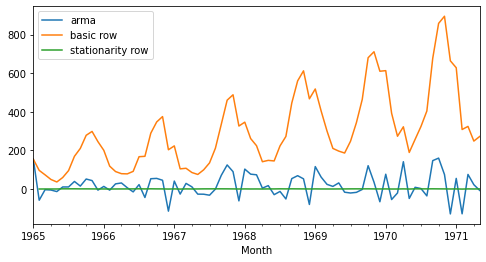

In [99]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
arma_mod.resid.plot(ax=ax, label='arma')
df.plot(label='basic row')
df3s['Count'].plot(label='stationarity row')
plt.legend()
plt.show()


видно, что стацонарный ряд в итоге сглаживает данные исходного (нестационарного) ряда

In [100]:
# построим отчет по выбранным параметрам
model = ARIMA(df, order=(best_pdq)) # p, d и q
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                   77
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -423.106
Date:                Mon, 01 May 2023   AIC                            858.212
Time:                        21:57:30   BIC                            872.197
Sample:                    01-01-1965   HQIC                           863.801
                         - 05-01-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3580      0.099     13.651      0.000       1.163       1.553
ar.L2         -0.3753      0.168     -2.230      0.026      -0.705      -0.045
ar.L3         -0.3497      0.099     -3.534      0.0

# Модели GARCH

In [101]:
from arch import arch_model

Авторегрессионные модели могут быть разработаны для одномерных данных временных рядов, которые являются стационарными (AR), имеют тренд (ARIMA) и имеют сезонный компонент (SARIMA).

Одним из аспектов одномерного временного ряда, который эти модели авторегрессии не моделируют, является изменение дисперсии во времени.

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [102]:
df=pd.Series(sales_of_company_x ["Count"])
dfG = df[:-5]

In [103]:
# Используем оптимальные параметры, полученные из ARIMA
p_ = 3
o_ = 1
q_ = 2

# Использование распределение Т student обычно дает хорошие результаты
am = arch_model(dfG, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
am2 = arch_model(df3s, p=p_, o=o_, q=q_, dist='StudentsT')
res2 = am2.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -466.085
Distribution:      Standardized Student's t   AIC:                           950.171
Method:                  Maximum Likelihood   BIC:                           970.661
                                              No. Observations:                   72
Date:                      Mon, May 01 2023   Df Residuals:                       71
Time:                              21:57:31   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [104]:
forecast = res.forecast(horizon=36)
forecast2 = res2.forecast(horizon=36)

In [105]:
forecast

In [106]:
forecast.residual_variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.27,h.28,h.29,h.30,h.31,h.32,h.33,h.34,h.35,h.36
Month,,,,,,,,,,,,,,,,,,,,,
1965-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3> Построим график изменения дисперсии (нестационарного ряда)

[185476.01664791  98422.64511511  61525.68014178  45887.15862018
  39258.88023581  36449.53062562  35258.80736769  34754.12761127
  34540.22261291  34449.56046975  34411.13395207  34394.84714029
  34387.9440886   34385.01827823  34383.7781939   34383.25259279
  34383.02982042  34382.93539991  34382.89538043  34382.87841846
  34382.87122924  34382.86818214  34382.86689065  34382.86634326
  34382.86611125  34382.86601292  34382.86597124  34382.86595357
  34382.86594609  34382.86594291  34382.86594157  34382.865941
  34382.86594076  34382.86594065  34382.86594061  34382.86594059]


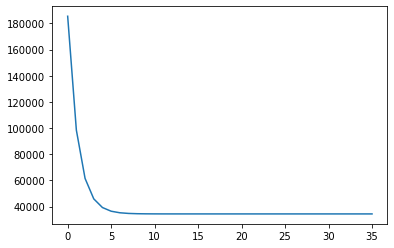

In [107]:
print(forecast.residual_variance.iloc[-1].values)
plt.plot(forecast.residual_variance.iloc[-1].values)

<h3> И график изменения дисперсии (стационарного ряда)

[0.07973709 0.06831091 0.07940407 0.07050968 0.07931898 0.07241157
 0.07942167 0.07407303 0.07966514 0.07553872 0.08001271 0.07684405
 0.0804358  0.07801711 0.0809122  0.07908023 0.08142471 0.08005121
 0.08196002 0.08094428 0.08250789 0.08177084 0.08306051 0.08254008
 0.08361193 0.08325942 0.08415766 0.08393489 0.08469439 0.08457142
 0.08521968 0.08517307 0.0857318  0.0857432  0.08622955 0.08628461]


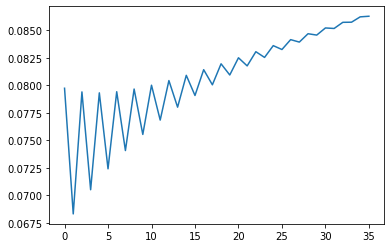

In [108]:
print(forecast2.residual_variance.iloc[-1].values)
plt.plot(forecast2.residual_variance.iloc[-1].values)

<h3> Получился возрастающий ряд с уменьшением колебаний дисперсии.

# Проанализируем также ряд "Series/daily-total-female-births-in-cal"

In [109]:
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")
female_births

,Date,Count
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [110]:
female_births["Month"] = pd.to_datetime(female_births["Date"])
female_births2=female_births
female_births.set_index('Month', inplace = True)

dfS = pd.Series(female_births["Count"])
dfS

Month
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: Count, Length: 365, dtype: int64

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


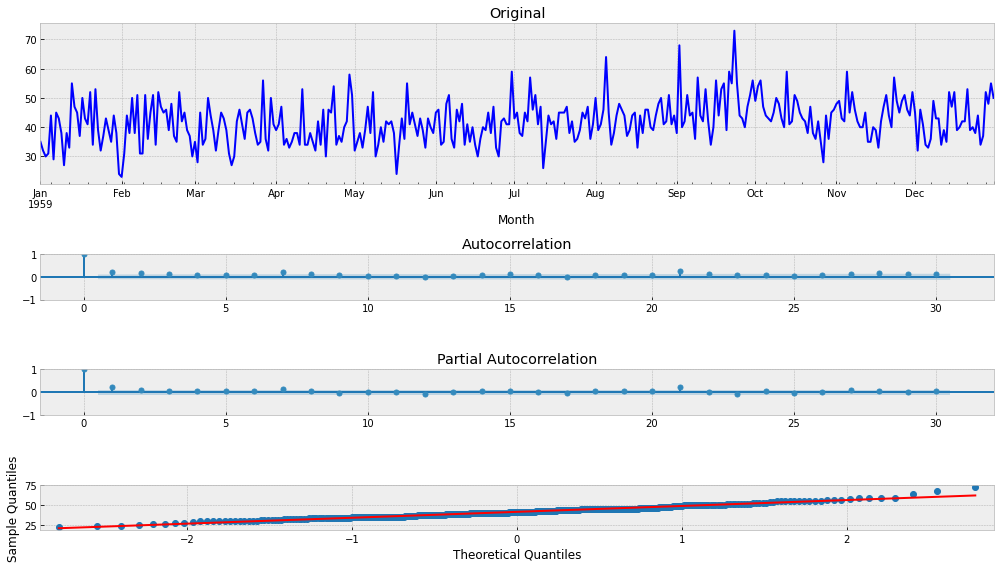

In [111]:
tsplot(dfS, lags=30)

Ряд изначально стационарный

In [112]:
import itertools
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
dfS=pd.Series(female_births["Count"])

p = range(0,5)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(dfS, order = params)
  result_test = model_test.fit()
  if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

(2, 2, 2) 34.8178889670058


In [113]:
arma_mod = ARIMA(dfS, order=best_pdq).fit()
print(arma_mod.params)

ar.L1        0.001119
ar.L2        0.998881
ma.L1       -1.999998
ma.L2        0.999998
sigma2    1675.195428
dtype: float64


In [114]:
p_ = 2
o_ = 2
q_ = 2

am = arch_model(dfS, p=p_, o=o_, q=q_, dist='StudentsT')
res3 = am.fit(update_freq=5, disp='off')
print(res3.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1241.85
Distribution:      Standardized Student's t   AIC:                           2501.71
Method:                  Maximum Likelihood   BIC:                           2536.81
                                              No. Observations:                  365
Date:                      Mon, May 01 2023   Df Residuals:                      364
Time:                              21:57:46   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            41

In [115]:
forecast3 = res3.forecast(horizon=36)

[49.59606202 54.86997678 50.12804628 54.27159487 50.53953018 53.79463602
 50.85704652 53.41389616 51.10136857 53.10947134 51.28875103 52.86563503
 51.43190475 52.66995429 51.54076204 52.51259365 51.62307756 52.38576697
 51.68489997 52.28330551 51.73094214 52.20031772 51.7648715  52.13292101
 51.78953785 52.07803036 51.80715201 52.03319158 51.81942575 51.99644979
 51.82768153 51.96624561 51.83293839 51.9413332  51.83597914 51.92071556]


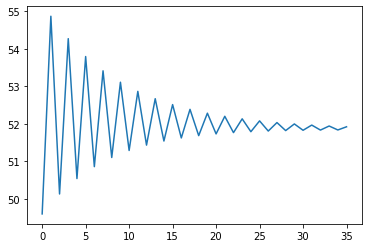

In [116]:
print(forecast3.residual_variance.iloc[-1].values)
plt.plot(forecast3.residual_variance.iloc[-1].values)

<h3> В отличие от предыдущего примера (стационарного ряда) получился горизонтальный график с уменьшением колебаний дисперсии

<h2> Можно сделать вывод,что модели достаточно хорошо предсказывают как значения стационарных рядов, так и нестационарных. Но для нестационарных рядов при выходе на прямую линию дисперсии - необходимо несколько периодов. При этом до выхода на эту линию - дисперсия может иметь большие значения, что несет высокий риск ошибки предсказаний на ранних стадиях. Если сравнивать 2 стационарных ряда между собой, то для первого ряда следует "улучшить" значение статционарности чтобы избавиться от возрастающего значения средней дисперсии. 